In [ ]:
Data Preparation

# Loading the data

In [ ]:
import pandas as pd
df = pd.read_csv('../Data/intermediate/citypm25.csv', parse_dates=['Date'])
df.sample(5)

,Date,Country,City,Median_PM25,Lat,Long
503505,2019-12-10,CN,Changsha,158.0,28.19874,112.97087
334409,2020-03-10,IT,Modena,72.0,44.64783,10.92539
534964,2015-05-11,SG,Singapore,46.0,1.28967,103.85007
155081,2018-03-02,CA,Kitchener,9.0,43.42537,-80.51120
427834,2020-08-21,CN,Ningbo,65.0,29.87819,121.54945


In [ ]:
import ee
# ee.Authenticate() # Run once to link your EE account

In [ ]:
ee.Initialize() # Run each session

In [ ]:
# A utility function to pull data for a set of locations
def sample(im, prop, lats, lons, scale=5000, reducer=ee.Reducer.first(), tileScale=4):
    points = []
    for lat, lon in zip(lats, lons):
        xy = ee.Geometry.Point([lon, lat])
        points.append(xy.buffer(scale))
    vals = im.reduceRegions(collection=ee.FeatureCollection(points), scale=scale, reducer=reducer, tileScale=tileScale).getInfo()
    if prop == '':
        return [v['properties'] for v in vals['features']]
    return [v['properties'][prop] for v in vals['features']]

# Example:
lights = ee.ImageCollection("NOAA/DMSP-OLS/CALIBRATED_LIGHTS_V4") # An image collection
lights = lights.filter(ee.Filter.date('2010-01-01', '2018-03-08')).first() # An image
vals = sample(lights, '', [-18.136], [30.15], scale=100) # See image value for a single location
vals

[{'avg_vis': 8.628110885620117, 'cf_cvg': 84}]

In [ ]:
from tqdm import tqdm # Progress bar

def add_static_vars(df, scale=5000):
    lights = ee.ImageCollection("NOAA/DMSP-OLS/CALIBRATED_LIGHTS_V4").filter(ee.Filter.date('2010-01-01', '2018-03-08')).first()
    pop = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density").filter(ee.Filter.date('2010-01-01', '2018-03-08')).first()
    ims = [lights, pop]

    for im in tqdm(ims):
        for i, reducer in enumerate([ee.Reducer.mean(), ee.Reducer.min(), ee.Reducer.max()]):
            sampled_values = sample(im, '', df['Lat'].values, df['Long'].values, reducer=reducer, scale=scale)
            for k in sampled_values[0].keys():
                arr = ['mean', 'min', 'max']
                df[k+'_'+str(scale)+'_' + arr[i]] = [sv[k] if k in sv.keys() else None for sv in sampled_values]
                if k == arr[i]:
                    df = df.rename(columns={k+'_'+str(scale)+'_' + arr[i]:'pop_density2010'+'_'+str(scale)+'_' + arr[i]})
    return df

In [ ]:
# Example
cities = df.groupby('City').first().reset_index()
cities.head()

,City,Date,Country,Median_PM25,Lat,Long
0,Abidjan,2020-08-02,CI,70.0,5.35444,-4.00167
1,Abu Dhabi,2019-05-14,AE,132.0,24.45118,54.39696
2,Accra,2020-06-09,GH,50.0,5.55602,-0.19690
3,Adapazarı,2015-12-28,TR,119.0,40.78056,30.40333
4,Addis Ababa,2019-05-10,ET,63.0,9.02497,38.74689


In [ ]:
add_static_vars(cities.head().copy()) # Show the result on the first 5 cities

100%|██████████| 2/2 [00:06<00:00,  3.04s/it]


,City,Date,Country,Median_PM25,Lat,Long,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,Abidjan,2020-08-02,CI,70.0,5.35444,-4.00167,137.458238,15.998734,160.062439,16,164.259094,16,6520.705998,3082.400635,14800.669922
1,Abu Dhabi,2019-05-14,AE,132.0,24.45118,54.39696,556.621354,17.788571,475.282532,11,727.158020,23,38.947327,38.947327,38.947327
2,Accra,2020-06-09,GH,50.0,5.55602,-0.19690,119.459692,15.767176,89.985809,8,167.339310,17,11249.964753,11258.493164,11258.494141
3,Adapazarı,2015-12-28,TR,119.0,40.78056,30.40333,92.085145,29.341346,38.168736,9,157.619995,50,668.729353,623.649292,777.632080
4,Addis Ababa,2019-05-10,ET,63.0,9.02497,38.74689,64.881196,55.146801,48.983185,12,79.473587,94,13177.830901,7696.010742,16855.011719


In [ ]:
from datetime import timedelta

# Image Collections
gfs = ee.ImageCollection("NOAA/GFS0P25") # Weather data

S5p_collections = {} # Sentinel 5p data, which comes in multiple collections
for COL in ['L3_NO2', 'L3_O3', 'L3_CO', 'L3_HCHO', 'L3_AER_AI', 'L3_SO2', 'L3_CH4', 'L3_CLOUD']: #
    S5p_collections[COL] = ee.ImageCollection('COPERNICUS/S5P/OFFL/'+COL).map(lambda image: image.addBands(image.metadata('system:time_start')))
# Properties for each image we want to keep
s5p_props = {
    'L3_NO2':['NO2_column_number_density', 'tropospheric_NO2_column_number_density', 'stratospheric_NO2_column_number_density', 'NO2_slant_column_number_density', 'tropopause_pressure', 'absorbing_aerosol_index'],
    'L3_O3':['O3_column_number_density', 'O3_effective_temperature'],
    'L3_CO':['CO_column_number_density', 'H2O_column_number_density', 'cloud_height'],
    'L3_HCHO':['tropospheric_HCHO_column_number_density', 'tropospheric_HCHO_column_number_density_amf', 'HCHO_slant_column_number_density'],
    'L3_CLOUD':['cloud_fraction', 'cloud_top_pressure', 'cloud_top_height', 'cloud_base_pressure', 'cloud_base_height', 'cloud_optical_depth', 'surface_albedo'],
    'L3_AER_AI':['absorbing_aerosol_index', 'sensor_altitude', 'sensor_azimuth_angle', 'sensor_zenith_angle', 'solar_azimuth_angle', 'solar_zenith_angle']
}

def add_timeseries(df, dates, reducer=ee.Reducer.first()):
    # Prepare dataframe with date x city
    date_col = []
    city_col = []
    for d in dates:
        for c in df.City.unique():
            date_col.append(d)
            city_col.append(c)

    data = pd.DataFrame({
        'Date':date_col,
        'City':city_col
    })
    data = pd.merge(data, df[['City', 'Lat', 'Long']], how='left', on='City')

    for d in tqdm(dates):
        # Weather is easy - a single image from the right date
        weather_image = gfs.filter(ee.Filter.date(str(d.date()), str((d+timedelta(days=1)).date()))).first() # Filter to get the relevant image
        # For the sentinel data, we get images from each collection and merge them
        s5p_images = []
        for COL in ['L3_NO2', 'L3_O3', 'L3_CO', 'L3_HCHO', 'L3_CLOUD', 'L3_AER_AI']:
            collection = S5p_collections[COL].filter(ee.Filter.date(str((d-timedelta(days=5)).date()), str(d.date())))
            image = collection.qualityMosaic('system:time_start') # The most recent image
            image = image.select(s5p_props[COL])
            s5p_images.append(image)
        s5p_image = ee.ImageCollection(s5p_images).toBands() # Merge into one image

        # Sample the weather data
        samples = sample(weather_image, '', df['Lat'].values, df['Long'].values, reducer=reducer)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]

        # Sample the sentinel data
        samples = sample(s5p_image, '', df['Lat'].values, df['Long'].values)
        for prop in samples[0].keys():
            data.loc[data.Date==d, prop] = [p[prop] for p in samples]

    return data

In [ ]:
dates = pd.date_range('2020-01-01', '2020-01-04', freq='1D')
add_timeseries(cities.head(2).copy(), dates) # Show the result on the first 2 cities

100%|██████████| 4/4 [00:27<00:00,  6.84s/it]


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2020-01-01,Abidjan,5.35444,-4.00167,46.900002,71.599998,0.01616,27.196222,-1.279448,0.737317,...,12.763545,2393.725357,76400.444475,0.210954,0.443768,829252.673662,-99.609861,34.373530,-139.892125,37.710792
1,2020-01-01,Abu Dhabi,24.45118,54.39696,13.700000,57.900002,0.00938,21.856226,1.070552,2.427317,...,8.218344,136.424788,100136.463061,0.116232,-0.896661,829852.620659,68.905130,51.364916,-168.537860,48.372729
2,2020-01-02,Abidjan,5.35444,-4.00167,39.100002,78.400002,0.01718,26.726831,-0.983623,-0.127395,...,7.834197,2983.145825,71068.492760,0.228787,0.074545,829199.802618,77.505699,1.974827,-145.461944,34.740573
3,2020-01-02,Abu Dhabi,24.45118,54.39696,24.700001,78.900002,0.01293,22.086816,2.776377,-0.837395,...,7.018234,12.623063,101288.169817,0.204431,-0.606618,829409.030932,-93.015536,62.406931,-146.568458,55.436224
4,2020-01-03,Abidjan,5.35444,-4.00167,23.700001,21.100000,0.00431,25.726526,-1.589570,-1.838108,...,7.834197,2983.145825,71068.492760,0.228787,0.249956,829102.729933,73.809871,37.207033,-151.997805,32.198350
5,2020-01-03,Abu Dhabi,24.45118,54.39696,22.700001,68.300003,0.01121,22.106531,-2.949570,0.211892,...,10.703247,3268.644538,69699.709658,0.209119,-1.097314,829466.921028,-96.494056,45.957917,-151.247315,53.077992
6,2020-01-04,Abidjan,5.35444,-4.00167,24.500000,27.800001,0.00602,26.551019,-0.914272,-1.219441,...,4.439643,4256.121642,60974.572300,0.163556,0.270056,828989.209522,71.186212,58.490274,-159.528799,30.152806
7,2020-01-04,Abu Dhabi,24.45118,54.39696,21.500000,57.100002,0.01013,23.381036,-2.624272,2.740559,...,6.975509,893.990053,92765.830926,0.193594,-0.180495,829518.879536,-100.853115,18.401694,-156.296864,51.042549


In [ ]:
cities = df.groupby('City').first().reset_index() # The locations to query
cities.head()

,City,Date,Country,Median_PM25,Lat,Long
0,Abidjan,2020-08-02,CI,70.0,5.35444,-4.00167
1,Abu Dhabi,2019-05-14,AE,132.0,24.45118,54.39696
2,Accra,2020-06-09,GH,50.0,5.55602,-0.19690
3,Adapazarı,2015-12-28,TR,119.0,40.78056,30.40333
4,Addis Ababa,2019-05-10,ET,63.0,9.02497,38.74689


In [ ]:
cities.columns

Index(['City', 'Date', 'Country', 'Median_PM25', 'Lat', 'Long'], dtype='object')

In [ ]:
# Add static vars
cities_w_static = add_static_vars(cities.copy())
# Get just City + satellite data
cities_w_static = cities_w_static.drop(['Date', 'Median_PM25', 'Lat', 'Long', 'Country'], axis=1)
# Merge with df
df = pd.merge(df, cities_w_static, on='City')
df.head()

100%|██████████| 2/2 [00:34<00:00, 17.32s/it]


,Date,Country,City,Median_PM25,Lat,Long,avg_vis_5000_mean,cf_cvg_5000_mean,avg_vis_5000_min,cf_cvg_5000_min,avg_vis_5000_max,cf_cvg_5000_max,pop_density2010_5000_mean,pop_density2010_5000_min,pop_density2010_5000_max
0,2016-02-15,SE,Stockholm,17.0,59.32938,18.06871,519.868312,15.459027,285.276917,15,681.321045,16,6005.806976,1700.715698,11526.897461
1,2016-03-11,SE,Stockholm,54.0,59.32938,18.06871,519.868312,15.459027,285.276917,15,681.321045,16,6005.806976,1700.715698,11526.897461
2,2016-04-18,SE,Stockholm,14.0,59.32938,18.06871,519.868312,15.459027,285.276917,15,681.321045,16,6005.806976,1700.715698,11526.897461
3,2016-04-27,SE,Stockholm,23.0,59.32938,18.06871,519.868312,15.459027,285.276917,15,681.321045,16,6005.806976,1700.715698,11526.897461
4,2016-05-25,SE,Stockholm,11.0,59.32938,18.06871,519.868312,15.459027,285.276917,15,681.321045,16,6005.806976,1700.715698,11526.897461


In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D') # Two yers of data

In [ ]:
# Add timeseries
ts = add_timeseries(cities.copy(), dates, reducer=ee.Reducer.mean())
ts.head()

100%|██████████| 579/579 [2:41:43<00:00, 16.76s/it]  


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2019-01-01,Abidjan,5.320357,-4.016107,42.386395,80.000000,0.018230,27.433191,1.581902,1.657090,...,7.02234,5520.22,51728,0.263068,0.426532,829007,71.1993,58.4905,-158.995,30.4407
1,2019-01-01,Abu Dhabi,24.453835,54.377401,23.007726,59.836009,0.010487,23.244091,-3.186343,-0.870399,...,11.9874,699.837,93964.2,0.14967,0.14794,829544,-100.876,18.2356,-156.023,51.3845
2,2019-01-01,Accra,5.560014,-0.205744,47.586395,75.800003,0.017800,27.943170,1.521902,1.137090,...,6.68784,3563.54,66223.3,0.247198,0.351532,829069,73.1984,42.3903,-153.298,32.1965
3,2019-01-01,Adapazarı,40.784799,30.399683,6.086396,72.245679,0.002802,0.383724,-0.509019,1.829587,...,4.16143,306.514,98038.7,0.128325,-0.910631,832034,-95.2349,45.6532,-157.312,67.276
4,2019-01-01,Addis Ababa,9.010793,38.761253,7.786396,67.200005,0.006980,10.633173,-0.978098,-0.962910,...,4.86416,2447.39,74947.2,0.203094,-0.397807,829010,-96.9514,53.8618,-139.207,42.7149


In [ ]:
# Save
df.to_csv('../Data/intermediate/df_w_static.csv', index=False)
ts.to_csv('../Data/intermediate/timeseries.csv', index=False)

In [ ]:
za_cities = pd.read_csv('../Data/city_locations/za_cities.csv').rename(columns={'lat':'Lat', 'lng':'Long', 'city':'City'})
za_cities = za_cities[za_cities.columns[:3]]
za_cities.head()

,City,Lat,Long
0,Johannesburg,-26.205171,28.049815
1,Cape Town,-33.925839,18.423218
2,Benoni,-26.190851,28.311338
3,Durban,-29.857896,31.029198
4,Pretoria,-25.706944,28.229444


In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D')

In [ ]:
# Add static vars
za_cities_w_static = add_static_vars(za_cities.copy())
za_cities_w_static.to_csv('../Data/intermediate/za_cities_w_static.csv', index=False)

100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


In [ ]:
# Add timeseries
ts = add_timeseries(za_cities.copy(), dates, reducer=ee.Reducer.mean())
ts.head()

100%|██████████| 579/579 [39:35<00:00,  4.10s/it]


,Date,City,Lat,Long,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,...,4_cloud_optical_depth,4_cloud_top_height,4_cloud_top_pressure,4_surface_albedo,5_absorbing_aerosol_index,5_sensor_altitude,5_sensor_azimuth_angle,5_sensor_zenith_angle,5_solar_azimuth_angle,5_solar_zenith_angle
0,2019-01-01,Johannesburg,-26.205171,28.049815,34.186398,74.099998,0.010470,16.683191,-1.538098,0.167090,...,102.767,6783.32,35329,0.230169,-1.041854,836021.393349,76.106556,57.231740,-81.129907,14.711944
1,2019-01-01,Cape Town,-33.925839,18.423218,13.456188,81.156772,0.011407,19.436617,0.678183,3.078934,...,6.92981,776.085,91716.9,0.141995,-1.079521,840342.500000,-103.971020,21.037430,-76.135757,28.994538
2,2019-01-01,Benoni,-26.190851,28.311338,34.186398,75.099998,0.010280,16.263177,-1.558098,0.877090,...,84.7966,6417.37,37356.5,0.22725,-1.116247,836044.182694,76.082842,56.409138,-81.389698,14.935419
3,2019-01-01,Durban,-29.857896,31.029198,38.111395,91.000004,0.016060,22.997341,-1.008098,-2.501243,...,15.5337,3051.12,96140.5,0.0963829,-2.577254,837650.235378,76.360290,49.055131,-71.997638,17.888265
4,2019-01-01,Pretoria,-25.706944,28.229444,37.486397,74.099998,0.011030,18.023187,-1.598098,3.107090,...,92.2256,5539.09,44037.8,0.21658,-0.988038,835856.500000,76.010284,56.406475,-83.254417,14.821662


In [ ]:
ts.to_csv('../Data/intermediate/za_cities_timeseries.csv', index=False)

In [ ]:
world_cities = pd.read_csv('../Data/simplemaps_worldcities_basicv1.6/worldcities.csv')
world_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [ ]:
af_iso2 = ['DZ','AO','BJ','BW','BF','BI','CM','CV','CF','KM','CD','DJ','EG','GQ','ER','ET','GA',
'GM','GH','GN','GW','CI','KE','LS','LR','LY','MG','MW','ML','MR','MU','MA','MZ','NE','NG','CG',
'RE','RW','SH','ST','SN','SC','SL','SO','ZA','SS','SD','SZ','TZ','TG','TN','UG','EH','ZM','ZW']
af_cities = world_cities.loc[world_cities.iso2.isin(af_iso2)].rename(columns={'lat':'Lat', 'lng':'Long', 'city':'City'})
af_cities.shape

(1466, 11)

In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D')
# Add static vars
af_cities_w_static = add_static_vars(af_cities.copy())
af_cities_w_static.to_csv('../Data/processed/af_cities_w_static.csv', index=False)

100%|██████████| 2/2 [02:13<00:00, 66.67s/it]


In [ ]:
ts = add_timeseries(af_cities.copy(), dates, reducer=ee.Reducer.mean())
ts.to_csv('../Data/processed/af_cities_timeseries.csv', index=False)
ts.head()

In [ ]:
# Load the cities we already have
za_cities = pd.read_csv('../Data/raw/za_cities.csv').rename(columns={'lat':'Lat', 'lng':'Long', 'city':'City'})
za_cities = za_cities[za_cities.columns[:3]]
za_cities.head()

,City,Lat,Long
0,Johannesburg,-26.205171,28.049815
1,Cape Town,-33.925839,18.423218
2,Benoni,-26.190851,28.311338
3,Durban,-29.857896,31.029198
4,Pretoria,-25.706944,28.229444


In [ ]:
pop_centers = pd.read_csv('../Data/raw/sampled_pop_centers.csv')
pop_centers.head()

,system:index,0_latitude,0_longitude,1_population_density,2_labels,2_population_density,ID,.geo
0,0_0,-31.320833,27.812500,1852.2110,107103599474910,1,0,NaN
1,1_0,-31.320833,27.820833,3827.1555,107103599474910,1,1,NaN
2,2_0,-31.329167,27.820833,2541.6377,107103599474910,1,2,NaN
3,3_0,-31.329167,27.829167,2266.2512,107103599474910,1,3,NaN
4,4_0,-31.379167,26.354167,4791.9062,106351980198117,1,4,NaN


In [ ]:
pop_centers = pop_centers[pop_centers['1_population_density'] > 1000]

In [ ]:
pop_centers.columns

Index(['system:index', '0_latitude', '0_longitude', '1_population_density',
       '2_labels', '2_population_density', 'ID', '.geo'],
      dtype='object')

In [ ]:
pcs = pop_centers.groupby('2_labels').mean().drop(['.geo'], axis=1).reset_index()
pcs['population'] = pop_centers.groupby('2_labels').sum()['2_population_density']
print(pcs.shape)
pcs.head()

(709, 7)


,2_labels,0_latitude,0_longitude,1_population_density,2_population_density,ID,population
0,101906689046502,-29.264167,17.732500,1864.426140,1.0,3539.000000,NaN
1,101979703490581,-29.650833,17.872500,2038.622720,1.0,3555.000000,NaN
2,101988293425553,-32.812500,17.891667,1100.177050,1.0,597.500000,NaN
3,102001178327463,-33.007197,17.920076,3090.803955,1.0,632.363636,NaN
4,102018358196232,-29.543056,17.948611,1496.952667,1.0,3547.000000,NaN


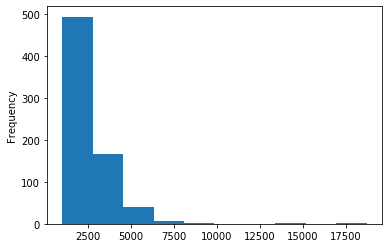

In [ ]:
pcs['1_population_density'].plot(kind='hist')

In [ ]:
# Filter out those within a few km of the cities we;ve already done
labels = []
for lab, lat, lon in pcs[['2_labels', '0_latitude', '0_longitude']].values:
    close = False
    for clat, clon in za_cities[['Lat', 'Long']].values:
        if ((lat-clat)**2 + (lon-clon)**2)**0.5 < 0.2: # ~20km
            close=True
            break
    if not close:
        labels.append(lab)

len(labels)

496

In [ ]:
pcs = pcs.rename(columns={'2_labels':'City', '0_latitude':'Lat', '0_longitude':'Long'})
pcs = pcs.loc[pcs.City.isin(labels)]
pcs.to_csv('../Data/processed/pop_centers_sa.csv', index=False)

In [ ]:
dates = pd.date_range('2019-01-01', '2020-08-01', freq='1D')
# Add static vars
pcs_w_static = add_static_vars(pcs.copy())
pcs_w_static.to_csv('../Data/processed/pcs_w_static.csv', index=False)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:30<00:30, 30.51s/it]

100%|██████████| 2/2 [01:00<00:00, 30.45s/it]


In [ ]:
ts = add_timeseries(pcs.copy(), dates, reducer=ee.Reducer.mean())
ts.to_csv('../Data/processed/pcs_timeseries.csv', index=False)
ts.head()